# Data Loading and Plotting example

In [1]:
%matplotlib inline
import matplotlib
import sys 

sys.path.insert(0,'..')
from utils import plot_stroke

import math
import time

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sampler import SeriesSampler, sample_mix_gaussian, sample_mix_bernoulli
from modules import WRITER, mdn_loss_gaussian, mdn_loss_bernoulli, MDN_G, MDN_B

In [2]:
strokes = np.load('../data/strokes-py3.npy', allow_pickle=True)
with open('../data/sentences.txt') as f:
    texts = f.readlines()

total number of string/stroke pairs: 6000


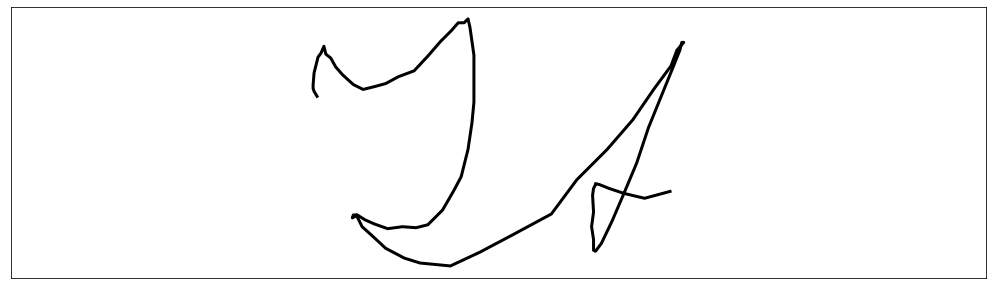

TEXT: It may be that the Common-

longest string length: 65
shortest string length: 9
longest stroke length: 1191
shortest stroke length: 301


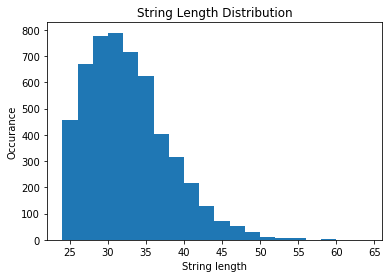

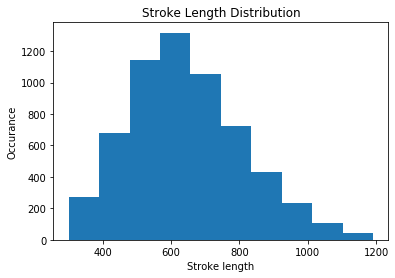

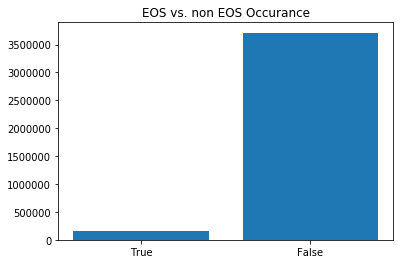

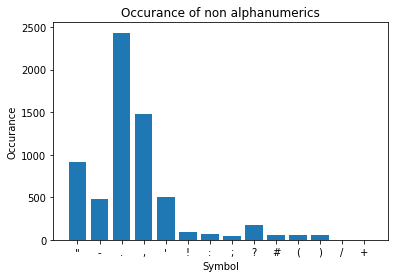

" occurance: 919
- occurance: 477
. occurance: 2434
, occurance: 1477
' occurance: 503
! occurance: 92
: occurance: 66
; occurance: 46
? occurance: 174
# occurance: 51
( occurance: 52
) occurance: 56
/ occurance: 3
+ occurance: 2


In [12]:
#explore the data
dp_count = len(texts)
print('total number of string/stroke pairs: {}'.format(dp_count))

idx = np.random.choice(dp_count)
stroke = strokes[idx]
text = texts[idx]
plot_stroke(stroke[:150])
print('TEXT:', text)



#visualize sequence & stroke length distribution
sequence_lengths = []
stroke_lengths = []
for i in range(dp_count):
    sequence_lengths.append(len(texts[i]))
    stroke_lengths.append(len(strokes[i]))
print('longest string length: {}'.format(max(sequence_lengths)))
print('shortest string length: {}'.format(min(sequence_lengths)))
print('longest stroke length: {}'.format(max(stroke_lengths)))
print('shortest stroke length: {}'.format(min(stroke_lengths)))

bin_width = 2
hist = plt.hist(sequence_lengths, bins=np.arange(24,63+bin_width,bin_width))
xlabel = plt.xlabel('String length')
ylabel = plt.ylabel('Occurance')
title = plt.title('String Length Distribution')
plt.show()
hist = plt.hist(stroke_lengths)
xlabel = plt.xlabel('Stroke length')
ylabel = plt.ylabel('Occurance')
title = plt.title('Stroke Length Distribution')
plt.show()

#how many end of stroke timesteps are there?
eos_count = {'True':0, 'False':0}
for s in strokes:
    for ts in s:
        #loop thru timesteps
        if ts[0] == 0:
            eos_count['False'] += 1
        else:
            eos_count['True'] += 1

bar = plt.bar(eos_count.keys(), eos_count.values())
title = plt.title('EOS vs. non EOS Occurance')
plt.show()

#aside from alphanumerics, what kinds of characters are we expecting?
char_bank = ' abcdefghijkilmopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ-!:,.\'\"'
non_alphanumerics = {}
for t in texts:
    for c in t:
        #loop through characters
        if not (c.isalpha() or c.isnumeric() or c==' ' or c=='\n'):
            if not (c in non_alphanumerics):
                #new symbol, add to dictionary
                non_alphanumerics[c] = 1
            else:
                #increase count
                non_alphanumerics[c] += 1
bar = plt.bar(non_alphanumerics.keys(), non_alphanumerics.values())
xlabel = plt.xlabel('Symbol')
ylabel = plt.ylabel('Occurance')
title = plt.title('Occurance of non alphanumerics')
plt.show()

for key, value in zip(non_alphanumerics.keys(), non_alphanumerics.values()):
    print(key, "occurance:", value)

## Training Preparation
Dataset class, encoder, and other data utils moved to sampler.py

## Unconditional Training
models and loss functions moved to modules.py

In [3]:
v = 65
writer = WRITER_COND(vocab_dim=v)
writer = writer
b = 4
seq = 130
x = torch.randn(b,seq,3)
t = torch.randn(b,v,65)
print(x.shape)
print(t.shape)
pos, end, hidden_states = writer(x,t)

torch.Size([4, 130, 3])
torch.Size([4, 65, 65])


In [70]:
BATCH_SIZE = 512
EPOCH = 1
SEQUENCE_LEN = 150
DEVICE = torch.device('cuda')

sampler_train = SeriesSampler(texts, strokes, sequence_len=SEQUENCE_LEN)
dataloader_train = DataLoader(sampler_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
sampler_val = SeriesSampler(texts, strokes, sequence_len=SEQUENCE_LEN, val=True)
dataloader_val = DataLoader(sampler_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

writer = WRITER().double()
writer.to(DEVICE)
#small learning rate (1e-7) leads to nan...
opt = torch.optim.RMSprop(writer.parameters(), lr=1.0e-3)

#callback used to find optimal initial learning rate
#increase_lamb = lambda epoch: 1e-3 * 10**(epoch/20)
#lr_raise = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=increase_lamb)

lr_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=20, cooldown=10, min_lr=1e-6)


In [12]:
'''unconditional model training'''
#torch.autograd.set_detect_anomaly(True)
train_loss_history = []
val_loss_history = []
lr_history = []
val_freq = 10

start = time.time()
for e in range(EPOCH):
    
    iter_val = dataloader_val.__iter__()
    for b, batch in enumerate(dataloader_train):       
        X = batch[0]
        y = batch[1].double()
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        
        pos, end, hidden_states = writer(X)
        
        pos_loss = mdn_loss_gaussian(*pos, y[:,1:])
        eos_loss = mdn_loss_bernoulli(*end, y[:,0], pos_weight=1*torch.ones(1).to(DEVICE))
        loss_train = pos_loss + eos_loss
        
        loss_train.backward()
        opt.step()
        opt.zero_grad()
        
        if (b%val_freq == 0):
            periodic_event = True
        else:
            periodic_event = False
            
        
        if periodic_event:
            
            train_loss_history.append(loss_train.item())
            
            '''VALIDATION'''
            writer.eval()
            with torch.no_grad():
                X_val, y_val = next(iter_val,1)
                y_val = y_val.double()
                X_val = X_val.to(DEVICE)
                y_val = y_val.to(DEVICE)
                
                pos, end, hidden_states = writer(X_val)
                pos_loss_val = mdn_loss_gaussian(*pos, y_val[:,1:])
                eos_loss_val = mdn_loss_bernoulli(*end, y_val[:,0], pos_weight=1*torch.ones(1).to(DEVICE))
                loss_val = pos_loss_val + eos_loss_val
            print('batch {}, total loss: {:4f}, pos loss: {:4f}, eos loss: {:4f}, val loss: {:4f}'.format(
                b,
                loss_train, 
                pos_loss, 
                eos_loss,
                loss_val
            ))
            
            val_loss_history.append(loss_val.item())
            writer.train()
            '''VALIDATION OVER'''
            lr_plateau.step(loss_val)
            
            lr_history.append(opt.param_groups[0]['lr'])
            
            #learning rate search
            #lr_raise.step()
            #if(b>=120):
                #break
                
        
total_time = time.time()-start
print(total_time)

batch 0, total loss: 8.551783, pos loss: 7.204748, eos loss: 1.347035, val loss: 5.783822
batch 10, total loss: 3.850878, pos loss: 2.752545, eos loss: 1.098333, val loss: 4.068680
batch 20, total loss: 4.048456, pos loss: 2.670131, eos loss: 1.378324, val loss: 3.737041
batch 30, total loss: 3.743303, pos loss: 2.552717, eos loss: 1.190586, val loss: 3.883579
batch 40, total loss: 3.703199, pos loss: 2.481641, eos loss: 1.221558, val loss: 4.102774
batch 50, total loss: 4.186086, pos loss: 2.651006, eos loss: 1.535080, val loss: 3.752035
batch 60, total loss: 4.168157, pos loss: 2.695982, eos loss: 1.472175, val loss: 4.150637
batch 70, total loss: 4.101293, pos loss: 2.660365, eos loss: 1.440928, val loss: 3.982915
batch 80, total loss: 4.054086, pos loss: 2.644339, eos loss: 1.409746, val loss: 3.737594
batch 90, total loss: 3.875154, pos loss: 2.434569, eos loss: 1.440585, val loss: 3.655833
batch 100, total loss: 3.700836, pos loss: 2.478664, eos loss: 1.222173, val loss: 3.850745

batch 900, total loss: 2.062792, pos loss: 0.603725, eos loss: 1.459066, val loss: 1.671272
batch 910, total loss: 2.350994, pos loss: 0.833348, eos loss: 1.517646, val loss: 2.374597
batch 920, total loss: 1.701714, pos loss: 0.615268, eos loss: 1.086445, val loss: 2.113423
batch 930, total loss: 1.936861, pos loss: 0.695977, eos loss: 1.240884, val loss: 2.073988
batch 940, total loss: 1.791522, pos loss: 0.687590, eos loss: 1.103931, val loss: 1.880133
batch 950, total loss: 1.871756, pos loss: 0.631549, eos loss: 1.240207, val loss: 2.326882
batch 960, total loss: 2.057279, pos loss: 0.752079, eos loss: 1.305200, val loss: 2.158794
batch 970, total loss: 2.054896, pos loss: 0.760253, eos loss: 1.294644, val loss: 2.170507
batch 980, total loss: 1.938633, pos loss: 0.491515, eos loss: 1.447118, val loss: 1.981436
batch 990, total loss: 1.757264, pos loss: 0.501690, eos loss: 1.255574, val loss: 1.532428
batch 1000, total loss: 1.893790, pos loss: 0.816009, eos loss: 1.077781, val lo

batch 1790, total loss: 1.692381, pos loss: 0.476705, eos loss: 1.215676, val loss: 1.609270
batch 1800, total loss: 1.892124, pos loss: 0.496275, eos loss: 1.395849, val loss: 1.910719
batch 1810, total loss: 1.575540, pos loss: 0.438737, eos loss: 1.136803, val loss: 1.321296
batch 1820, total loss: 1.836544, pos loss: 0.536579, eos loss: 1.299965, val loss: 1.946252
batch 1830, total loss: 1.866347, pos loss: 0.527983, eos loss: 1.338363, val loss: 1.783345
batch 1840, total loss: 1.976731, pos loss: 0.410681, eos loss: 1.566049, val loss: 1.867309
batch 1850, total loss: 1.741339, pos loss: 0.505693, eos loss: 1.235645, val loss: 1.744204
batch 1860, total loss: 1.707869, pos loss: 0.368259, eos loss: 1.339610, val loss: 1.571962
batch 1870, total loss: 1.994722, pos loss: 0.559705, eos loss: 1.435017, val loss: 1.580811
batch 1880, total loss: 1.839550, pos loss: 0.432502, eos loss: 1.407048, val loss: 1.649534
batch 1890, total loss: 1.859446, pos loss: 0.400124, eos loss: 1.4593

batch 2680, total loss: 1.320092, pos loss: 0.152564, eos loss: 1.167528, val loss: 1.806343
batch 2690, total loss: 1.510584, pos loss: 0.298260, eos loss: 1.212324, val loss: 1.610562
batch 2700, total loss: 1.808589, pos loss: 0.405308, eos loss: 1.403281, val loss: 1.394546
batch 2710, total loss: 1.671118, pos loss: 0.407627, eos loss: 1.263492, val loss: 1.558602
batch 2720, total loss: 1.409248, pos loss: 0.336285, eos loss: 1.072964, val loss: 1.501530
batch 2730, total loss: 1.325131, pos loss: 0.302843, eos loss: 1.022288, val loss: 1.553789
batch 2740, total loss: 1.384410, pos loss: 0.386206, eos loss: 0.998203, val loss: 1.621428
batch 2750, total loss: 1.473682, pos loss: 0.310497, eos loss: 1.163185, val loss: 1.572105
batch 2760, total loss: 1.298485, pos loss: 0.385840, eos loss: 0.912645, val loss: 1.642957
batch 2770, total loss: 1.483585, pos loss: 0.381237, eos loss: 1.102348, val loss: 1.744062
batch 2780, total loss: 1.274733, pos loss: 0.254880, eos loss: 1.0198

batch 3570, total loss: 1.457354, pos loss: 0.375139, eos loss: 1.082215, val loss: 1.336393
batch 3580, total loss: 1.057538, pos loss: 0.175536, eos loss: 0.882002, val loss: 1.181823
batch 3590, total loss: 1.402716, pos loss: 0.229474, eos loss: 1.173243, val loss: 1.318296
batch 3600, total loss: 1.373542, pos loss: 0.287081, eos loss: 1.086461, val loss: 1.273366
batch 3610, total loss: 1.407672, pos loss: 0.240143, eos loss: 1.167529, val loss: 1.472263
batch 3620, total loss: 1.243735, pos loss: 0.230360, eos loss: 1.013375, val loss: 1.282592
batch 3630, total loss: 1.609497, pos loss: 0.463604, eos loss: 1.145893, val loss: 1.306039
batch 3640, total loss: 1.474329, pos loss: 0.187355, eos loss: 1.286974, val loss: 1.309563
batch 3650, total loss: 1.263089, pos loss: 0.105403, eos loss: 1.157686, val loss: 1.374683
batch 3660, total loss: 1.629500, pos loss: 0.341423, eos loss: 1.288077, val loss: 1.221485
batch 3670, total loss: 1.174459, pos loss: 0.203213, eos loss: 0.9712

batch 4460, total loss: 1.119591, pos loss: 0.190714, eos loss: 0.928877, val loss: 1.352125
batch 4470, total loss: 1.441249, pos loss: 0.237771, eos loss: 1.203478, val loss: 1.213581
batch 4480, total loss: 1.458205, pos loss: 0.282447, eos loss: 1.175757, val loss: 1.231140
batch 4490, total loss: 1.081990, pos loss: 0.165544, eos loss: 0.916447, val loss: 1.350628
batch 4500, total loss: 1.265788, pos loss: 0.184744, eos loss: 1.081044, val loss: 1.081954
batch 4510, total loss: 1.387020, pos loss: 0.344229, eos loss: 1.042791, val loss: 1.243493
batch 4520, total loss: 1.115413, pos loss: 0.259054, eos loss: 0.856358, val loss: 1.457169
batch 4530, total loss: 0.991362, pos loss: 0.089743, eos loss: 0.901619, val loss: 1.357831
batch 4540, total loss: 1.113441, pos loss: 0.210284, eos loss: 0.903157, val loss: 0.944174
batch 4550, total loss: 1.087755, pos loss: 0.140341, eos loss: 0.947414, val loss: 1.465934
batch 4560, total loss: 1.348019, pos loss: 0.273139, eos loss: 1.0748

batch 5350, total loss: 1.064416, pos loss: 0.154291, eos loss: 0.910125, val loss: 1.273432
batch 5360, total loss: 1.435932, pos loss: 0.191420, eos loss: 1.244512, val loss: 1.058872
batch 5370, total loss: 1.152217, pos loss: 0.030536, eos loss: 1.121680, val loss: 1.154007
batch 5380, total loss: 0.987613, pos loss: 0.087454, eos loss: 0.900159, val loss: 1.111517
batch 5390, total loss: 0.988723, pos loss: 0.080683, eos loss: 0.908039, val loss: 1.135206
batch 5400, total loss: 1.161251, pos loss: 0.166660, eos loss: 0.994591, val loss: 1.411706
batch 5410, total loss: 1.069520, pos loss: 0.182285, eos loss: 0.887234, val loss: 1.171843
batch 5420, total loss: 0.975656, pos loss: 0.066851, eos loss: 0.908805, val loss: 0.984773
batch 5430, total loss: 1.236090, pos loss: 0.266061, eos loss: 0.970029, val loss: 1.120823
batch 5440, total loss: 1.370907, pos loss: 0.098852, eos loss: 1.272054, val loss: 1.180433
batch 5450, total loss: 1.170987, pos loss: 0.206582, eos loss: 0.9644

In [96]:
#torch.save(writer.state_dict(), './first_try.pt')
#writer.load_state_dict(torch.load('../weights/02_20_2020_15_15/final.pt'))

<All keys matched successfully>

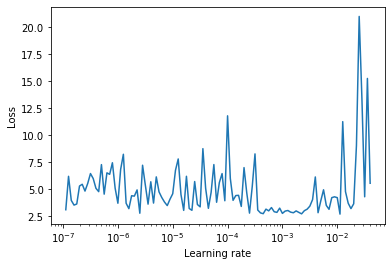

In [18]:
#learning rate search suggests ~10e-3 is a good initial learning rate
plt.semilogx(lr_history[:-2], train_loss_history[:-3])
xlabel = plt.xlabel('Learning rate')
ylabel = plt.ylabel('Loss')

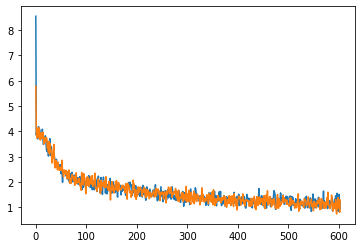

In [13]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)

## Conditional Training

In [4]:
BATCH_SIZE = 128
EPOCH = 1
SEQUENCE_LEN = 150
VOCAB = 65
DEVICE = torch.device('cuda')

sampler_train = SeriesSampler(texts, strokes, sequence_len=SEQUENCE_LEN, cond=True)
dataloader_train = DataLoader(sampler_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
sampler_val = SeriesSampler(texts, strokes, sequence_len=SEQUENCE_LEN, val=True, cond=True)
dataloader_val = DataLoader(sampler_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

writer = WRITER_COND(vocab_dim=VOCAB,device=DEVICE).double()
writer.to(DEVICE)
#small learning rate (1e-7) leads to nan...
opt = torch.optim.RMSprop(writer.parameters(), lr=1.0e-3)

lr_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=20, cooldown=10, min_lr=1e-6)

In [6]:
'''conditional model training'''
train_loss_history = []
val_loss_history = []
lr_history = []
val_freq = 10

start = time.time()
for e in range(EPOCH):
    
    iter_val = dataloader_val.__iter__()
    for b, batch in enumerate(dataloader_train):       
        X = batch[0].double()
        enc = batch[1].double()
        y = batch[2].double()
        X = X.to(DEVICE)
        enc = enc.to(DEVICE)
        y = y.to(DEVICE)
        
        pos, end, hidden_states = writer(X, enc)
        
        #for e in end:
            #print(e.shape)
            
        #print(y)
        pos_loss = mdn_loss_gaussian(*pos, y[:,1:])
        eos_loss = mdn_loss_bernoulli(*end, y[:,0], pos_weight=1*torch.ones(1).to(DEVICE))
        loss_train = pos_loss + eos_loss
        
        loss_train.backward()
        opt.step()
        opt.zero_grad()
        
        if (b%val_freq == 0):
            periodic_event = True
        else:
            periodic_event = False
            
        
        if periodic_event:
            
            train_loss_history.append(loss_train.item())
            
            '''VALIDATION'''
            writer.eval()
            with torch.no_grad():
                X_val, enc_val, y_val = next(iter_val,1)
                X_val = X_val.double()
                enc_val = enc_val.double()
                y_val = y_val.double()
                X_val = X_val.to(DEVICE)
                enc_val = enc_val.to(DEVICE)
                y_val = y_val.to(DEVICE)

                pos, end, hidden_states = writer(X_val, enc_val)
                pos_loss_val = mdn_loss_gaussian(*pos, y_val[:,1:])
                eos_loss_val = mdn_loss_bernoulli(*end, y_val[:,0], pos_weight=1*torch.ones(1).to(DEVICE))
                loss_val = pos_loss_val + eos_loss_val
            print('batch {}, total loss: {:4f}, pos loss: {:4f}, eos loss: {:4f}, val loss: {:4f}'.format(
                b,
                loss_train, 
                pos_loss, 
                eos_loss,
                loss_val
            ))
            
            val_loss_history.append(loss_val.item())
            writer.train()
            '''VALIDATION OVER'''
            lr_plateau.step(loss_val)
            
            lr_history.append(opt.param_groups[0]['lr'])
            
            #learning rate search
            #lr_raise.step()
            if(b>=30):
                break
                
        
total_time = time.time()-start
print(total_time)

batch 0, total loss: 3.368288, pos loss: 2.768501, eos loss: 0.599787, val loss: 3.008982
batch 10, total loss: 3.535269, pos loss: 3.011782, eos loss: 0.523488, val loss: 3.653218
batch 20, total loss: 3.205076, pos loss: 2.706014, eos loss: 0.499062, val loss: 3.339414
batch 30, total loss: 3.102479, pos loss: 2.644459, eos loss: 0.458020, val loss: 3.572937
38.7451868057251


## Evaluate

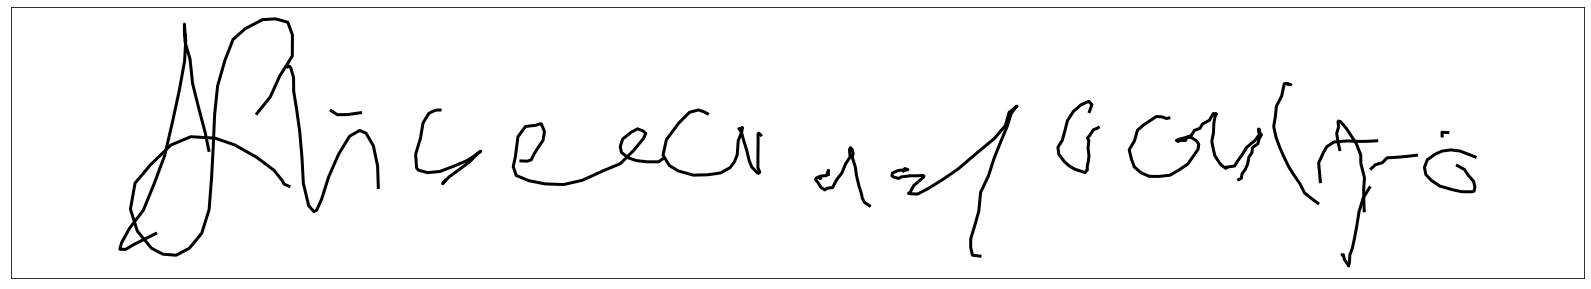

In [24]:
'''unconditional evaluation'''
writer = WRITER().double().cuda()
writer.load_state_dict(torch.load('../weights/02_20_2020_15_15/final.pt'))
samp = SeriesSampler(texts, strokes)
loader = DataLoader(samp, batch_size=1, shuffle=True, num_workers=1)
iterator = loader.__iter__()
X,y = next(iterator,1)
X = X.double().cuda()
#t = torch.randn(1,100,100).float().cuda()

with torch.no_grad():
    pos,end,hidden_states = writer(X)

eos = sample_mix_bernoulli(end[0], end[1])
step = sample_mix_gaussian(pos[0], pos[1], pos[2])

X = torch.zeros(1,1,3)
X[:,:,0] = eos
X[:,:,1:] = step
X = X.double().cuda()

be = []
dx = []
dy = []
for ts in range(500):
    with torch.no_grad():
        pos, end, hidden_states = writer(X, hidden_states)
    
    eos = sample_mix_bernoulli(end[0], end[1])
    step = sample_mix_gaussian(pos[0], pos[1], pos[2])
    X = torch.zeros(1,1,3)
    X[:,:,0] = eos
    X[:,:,1:] = step
    X = X.double().cuda()
    
    be.append(eos)
    dx.append(step[0])
    dy.append(step[1])

stroke = np.column_stack((be, dx, dy))
plot_stroke(stroke)

### Strokes

Each handwritten sentence is represented as a 2D array with T rows and 3 columns. T is the number of timesteps. The first column represents whether to interrumpt the current stroke (i.e. when the pen is lifted off the paper). The second and third columns represent the relative coordinates of the new point with respect to the last point. Please have a look at the plot_stroke if you want to understand how to plot this sequence.

In [11]:
stroke

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.15, -0.25],
       [ 0.  ,  0.25, -0.1 ],
       ...,
       [ 0.  ,  1.65, -0.05],
       [ 0.  ,  2.  ,  0.2 ],
       [ 1.  ,  2.05,  0.6 ]], dtype=float32)